<a href="https://colab.research.google.com/github/banihal/Working_With_ML/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import matplotlib.pyplot 
import cv2
print(os.listdir('../content/drive/My Drive/data'))
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator

['Scentless Mayweed', 'Common Chickweed', 'Maize', 'Common wheat', 'Sugar beet', 'Loose Silky-bent', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Fat Hen', 'Cleavers', 'Charlock', 'Black-grass']


Using TensorFlow backend.


In [ ]:
training_img = []
label = []

for dir_path in glob.glob('../content/drive/My Drive/data/*'):
  image_label = dir_path.split('/')[-1]
  for image_path in glob.glob(os.path.join(dir_path, '*.png')):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (64,64))
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    training_img.append(image)
    label.append(image_label)

training_img = np.array(training_img)

In [ ]:
label_to_id = {v:k for k,v in enumerate(np.unique(label))}
id_to_label = {v:k for k,v in label_to_id.items()}
label_to_id

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [ ]:
training_label_id = np.array([label_to_id[x] for x in label])
Y = np.array(training_label_id)
Y = to_categorical(Y, num_classes = 12)

In [ ]:
from keras.models import Model
from keras.layers.core import Dense,Dropout,Activation
from keras.layers import Conv2D
from keras.layers.pooling import AveragePooling2D,GlobalAveragePooling2D
from keras.layers import Input,Concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import RMSprop,Adamax
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler,EarlyStopping

In [ ]:
def conv_layer(x,concat_axis,nb_filter,dropout_rate=None,weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                          gamma_regularizer=l2(weight_decay),
                          beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter,(3,3),padding='same',kernel_regularizer=l2(weight_decay),use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

In [ ]:
def transition_layer(x,concat_axis,nb_filter,dropout_rate=None,weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                          gamma_regularizer=l2(weight_decay),
                          beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter,(1,1),padding='same',kernel_regularizer=l2(weight_decay),use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = AveragePooling2D((2,2),strides=(2,2))(x)
    return x

In [ ]:
def convolution_block(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution block consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    """
    
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels * bottleneckWidth, (1, 1), use_bias=False, kernel_regularizer=l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
    
    # Standard (BN-ReLU-Conv)
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    return x

In [ ]:
def DenseNet(input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None, dropout_rate=None,
             bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):
    """
    Arguments:
    input_shape  : shape of the input images. E.g. (28,28,1) for MNIST    
    dense_blocks : amount of dense blocks that will be created (default: 3)    
    dense_layers : number of layers in each dense block. You can also use a list for numbers of layers [2,4,3]
                   or define only 2 to add 2 layers at all dense blocks. -1 means that dense_layers will be calculated
                   by the given depth (default: -1)
    growth_rate  : number of filters to add per dense block (default: 12)
    nb_classes   : number of classes
    dropout_rate : defines the dropout rate that is accomplished after each conv layer (except the first one).
                   In the paper the authors recommend a dropout of 0.2 (default: None)
    bottleneck   : (True / False) if true it will be added in convolution block (default: False)
    compression  : reduce the number of feature-maps at transition layer. In the paper the authors recomment a compression
                   of 0.5 (default: 1.0 - will have no compression effect)
    weight_decay : weight decay of L2 regularization on weights (default: 1e-4)
    depth        : number or layers (default: 40)
 
    Returns:
    Model        : A Keras model instance
    """
    
    if nb_classes==None:
        raise Exception('Please define number of classes (e.g. num_classes=10). This is required for final softmax.')
    
    if compression <=0.0 or compression > 1.0:
        raise Exception('Compression have to be a value between 0.0 and 1.0. If you set compression to 1.0 it will be turn off.')
    
    if type(dense_layers) is list:
        if len(dense_layers) != dense_blocks:
            raise AssertionError('Number of dense blocks have to be same length to specified layers')
    elif dense_layers == -1:
        if bottleneck:
            dense_layers = (depth - (dense_blocks + 1))/dense_blocks // 2
        else:
            dense_layers = (depth - (dense_blocks + 1))//dense_blocks
        dense_layers = [int(dense_layers) for _ in range(dense_blocks)]
    else:
        dense_layers = [int(dense_layers) for _ in range(dense_blocks)]

    if K.common.image_dim_ordering() == "th":
        concat_axis = 1
    elif K.common.image_dim_ordering() == "tf":
        concat_axis = -1
        
    img_input = Input(shape=input_shape)
    nb_channels = growth_rate * 2

    
    print('Creating DenseNet')
    print('#############################################')
    print('Dense blocks: %s' % dense_blocks)
    print('Layers per dense block: %s' % dense_layers)
    print('#############################################')
    
    # Initial convolution layer
    x = Conv2D(nb_channels, (3,3), padding='same',strides=(1,1),
                      use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)
    
    # Building dense blocks
    for block in range(dense_blocks):
        
        # Add dense block
        x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate, dropout_rate, bottleneck, weight_decay)
        
        if block < dense_blocks - 1:  # if it's not the last dense block
            # Add transition_block
            x = transition_layer(x, nb_channels, dropout_rate, compression, weight_decay)
            nb_channels = int(nb_channels * compression)
    
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(nb_classes, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay))(x)
    
    densenet = Model(inputs=[img_input], outputs=[x], name="DenseNet")
    
    return densenet

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(training_img, Y, test_size = 0.05)

In [ ]:
model =         Densenet(nb_classes=12,
                          img_dim=(64,64,3),
                          depth = 34,
                          nb_dense_block = 6,
                          growth_rate=12,
                          nb_filter=32,
                          dropout_rate=0.25,
                          weight_decay=1E-4)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adamax(),
              metrics=["accuracy"])


In [ ]:
model_filepath = 'model.h5'
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=1e-5, patience=2, verbose=1)
msave = ModelCheckpoint(model_filepath, save_best_only=True)
aug = ImageDataGenerator(rotation_range=180, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [55]:
training = model.fit(aug.flow(X_train ,Y_train, batch_size=16),
               validation_data = (X_test,Y_test),
              epochs = 30,
               callbacks=[lr_reduce,annealer,msave],
               verbose = 1)

Epoch 1/30
207/207 [==============================] - 109s 527ms/step - loss: 1.8107 - accuracy: 0.8614 - val_loss: 2.2519 - val_accuracy: 0.7429
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


207/207 [==============================] - 109s 528ms/step - loss: 1.7543 - accuracy: 0.8698 - val_loss: 2.2209 - val_accuracy: 0.7486
Epoch 3/30
207/207 [==============================] - 109s 528ms/step - loss: 1.6799 - accuracy: 0.8849 - val_loss: 2.1764 - val_accuracy: 0.7200
Epoch 4/30
207/207 [==============================] - 110s 529ms/step - loss: 1.6155 - accuracy: 0.9024 - val_loss: 2.0441 - val_accuracy: 0.7771
Epoch 5/30
207/207 [==============================] - 110s 530ms/step - loss: 1.5559 - accuracy: 0.9109 - val_loss: 1.6463 - val_accuracy: 0.8914
Epoch 6/30
207/207 [==============================] - 110s 529ms/step - loss: 1.5328 - accuracy: 0.9127 - val_loss: 1.6313 - val_accuracy: 0.9086
Epoch 7/30
207/207 [==============================] - 110s 529ms/step - loss: 1.4845 - accuracy: 0.9160 - val_loss: 1.4806 - val_accuracy: 0.9029
Epoch 8/30
207/207 [==============================] - 110s 529ms/step - loss: 1.4457 - accuracy: 0.9275 - val_loss: 1.5035 - val_accura

In [45]:
model.save('model.h5')

In [ ]:
!pip install -U -q PyDrive


In [58]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [59]:
auth.authenticate_user()

In [60]:
gauth = GoogleAuth()


In [61]:
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)


In [62]:
model.save('final_model.h5')
model_file = drive.CreateFile({'title' : 'final_model.h5'})   
model_file.SetContentFile('final_model.h5')         
model_file.Upload()


In [76]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '13mEkEMiLS-UPvAMDQMopZo8fUbAfS7CG'})

In [77]:
last_weight_file = drive.CreateFile({'id': '13mEkEMiLS-UPvAMDQMopZo8fUbAfS7CG'}) 
last_weight_file.GetContentFile('final_model.mat')
model.load_weights('final_model.mat')

In [82]:
model.evaluate(X_test,
               Y_test,
               verbose = 1)

175/175 [==============================] - 3s 18ms/step


[1.3031543547766549, 0.954285740852356]

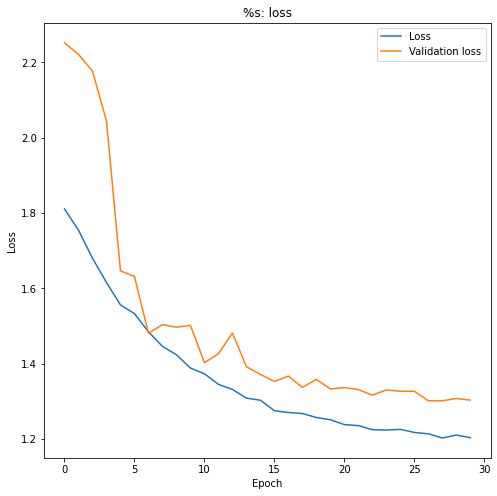

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(training.history['loss'], label="Loss")
plt.plot(training.history['val_loss'], label="Validation loss")
plt.title('%s: loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [66]:
print(Y_test[20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [73]:
image = X_test[20].reshape(-1,64,64,3)

In [74]:
Y_prd = model.predict(image)

In [75]:
print(Y_test[20], Y_prd)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] [[1.4371522e-06 7.1355071e-06 1.0523975e-05 9.0702361e-04 7.5557196e-08
  1.6465267e-04 3.2670494e-07 2.1268546e-05 5.9968075e-03 9.9287719e-01
  9.2630426e-06 4.2493020e-06]]
